# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
from pathlib import Path

import yaml
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_samples_df,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_tile_metadata, nd2_to_tiff
from lib.preprocess.file_utils import get_sample_fps

## SET PARAMETERS

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "analysis_root/"

Path(CONFIG_FILE_PATH).parent.mkdir(parents=True, exist_ok=True)
Path(ROOT_FP).mkdir(parents=True, exist_ok=True)

## SET PARAMETERS

### Paths to dataframes with sample information

- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: Path to directories with SBS/phenotype sample nd2 files. Set to `None` to ignore SBS/phenotype testing in this notebook.

### Pattern configurations for metadata extraction

#### SBS Configuration
- `SBS_PATH_PATTERN`: Regex pattern to match directory structure of SBS files
- `SBS_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile, "cycle""` to extract SBS processing information
- `SBS_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

#### Phenotype Configuration
- `PHENOTYPE_PATH_PATTERN`: Regex pattern to match directory structure of phenotype files  
- `PHENOTYPE_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile"` to extract phentoype processing information
- `PHENOTYPE_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

*Notes:*
- Paths can be absolute or relative to where workflows are run from
- Each pattern (path and sample) should have the same number of capture groups as pieces of metadata listed
- Metadata lists should be ordered to match the capture groups in their corresponding regex pattern
- For both path and sample patterns, numeric values (like cycle numbers) will automatically be converted to integers
- For Brieflow to run effectively, each sample fil epath should have an associated plate/well. For single plate/well screens manually add a plate/well to the file path dataframe.

In [ ]:
# paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = "config/phenotype_samples.tsv"

# Directory, pattern, and metadata for SBS sample nd2 files
SBS_IMAGES_DIR_FP = Path("/lab/barcheese01/brieflow_screens/denali-data/input_sbs/")
SBS_SAMPLE_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)__.*"
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
SBS_METADATA_ORDER_TYPE = {
    "plate": int,
    "well": str,
    "tile": int,
    "cycle": int,
}

# Directory, pattern, and metadata for phenotype sample nd2 files
PHENOTYPE_IMAGES_DIR_FP = Path("/lab/barcheese01/brieflow_screens/denali-data/input_ph/")
PHENOTYPE_SAMPLE_PATTERN = r"P(\d+)_Pheno_20x_Wells-([A-Z]\d+)_Points-(\d+)__.*"
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]
PHENOTYPE_METADATA_ORDER_TYPE = {
    "plate": int,
    "well": str,
    "tile": int,
}

You must supply a working regex to the _PATTERN variables. If you don't have experience with regex, you can use the following LLM prompt to generate the example sample patterns.

_Enter into a basic LLM chatbot_: Given ND2 filenames from your experiment, generate regex patterns to extract metadata. Return only the regex patterns with no explanation.

Example filenames:
[ENTER YOUR EXAMPLE FILES HERE]

Required regex patterns (return these exact variable assignments):

```python
SBS_PATH_PATTERN = r"..."      # To match file path structure
PHENOTYPE_PATH_PATTERN = r"..." # To match file path structure
```

The patterns should extract:

1. SBS pattern:
     - Plate number (after "plate_")
     - Cycle number (after "/c")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")

2. PHENOTYPE pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")

The patterns will be used like this:
```python
# Path pattern matching
path_match = re.search(PATH_PATTERN, filepath)
plate = path_match.group(1)
cycle = int(path_match.group(2))  # For SBS only

# Sample pattern matching
sample_match = re.search(SAMPLE_PATTERN, filename)
plate = sample_match.group(1)
well = sample_match.group(2)
```

Example patterns for reference:
```python
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)__.*"
PHENOTYPE_PATH_PATTERN = r"P(\d+)_Pheno_20x_Wells-([A-Z]\d+)_Points-(\d+)__.*"
```

## Create Sample DFs

In [ ]:
sbs_samples = create_samples_df(SBS_IMAGES_DIR_FP, SBS_SAMPLE_PATTERN, SBS_PATH_METADATA, SBS_METADATA_ORDER_TYPE)
# Save and display sample dataframe
sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)

# Create sample dataframe for phenotype
phenotype_samples = create_samples_df(PHENOTYPE_IMAGES_DIR_FP, PHENOTYPE_SAMPLE_PATTERN, PHENOTYPE_PATH_METADATA, PHENOTYPE_METADATA_ORDER_TYPE)
# Save and display sample dataframe
phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)

SBS samples:


,sample_fp,plate,well,tile,cycle
0,/lab/barcheese01/brieflow_screens/denali-data/...,1,A1,0,1
2262,/lab/barcheese01/brieflow_screens/denali-data/...,1,A1,0,2
3016,/lab/barcheese01/brieflow_screens/denali-data/...,1,A1,0,3
3770,/lab/barcheese01/brieflow_screens/denali-data/...,1,A1,0,4
4524,/lab/barcheese01/brieflow_screens/denali-data/...,1,A1,0,5
...,...,...,...,...,...
15076,/lab/barcheese01/brieflow_screens/denali-data/...,2,A2,376,7
15833,/lab/barcheese01/brieflow_screens/denali-data/...,2,A2,376,8
16587,/lab/barcheese01/brieflow_screens/denali-data/...,2,A2,376,9
9798,/lab/barcheese01/brieflow_screens/denali-data/...,2,A2,376,10


Phenotype samples:


,sample_fp,plate,well,tile
1,/lab/barcheese01/brieflow_screens/denali-data/...,1,A1,0
0,/lab/barcheese01/brieflow_screens/denali-data/...,1,A1,1
2,/lab/barcheese01/brieflow_screens/denali-data/...,1,A1,2
3,/lab/barcheese01/brieflow_screens/denali-data/...,1,A1,3
4,/lab/barcheese01/brieflow_screens/denali-data/...,1,A1,4
...,...,...,...,...
5582,/lab/barcheese01/brieflow_screens/denali-data/...,2,A2,1600
5583,/lab/barcheese01/brieflow_screens/denali-data/...,2,A2,1601
5584,/lab/barcheese01/brieflow_screens/denali-data/...,2,A2,1602
5585,/lab/barcheese01/brieflow_screens/denali-data/...,2,A2,1603


## Test Metadata Extraction

In [6]:
if SBS_IMAGES_DIR_FP is not None:
    # Extract metadata from test sbs sample
    test_sbs_metadata = extract_tile_metadata(
        sbs_samples["sample_fp"][0],
        sbs_samples["well"][0],
        sbs_samples["tile"][0],
        verbose=True,
    )
    print("SBS test metadata:")
    display(test_sbs_metadata)

if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Extract metadata from test phenotype sample
    test_phenotype_metadata = extract_tile_metadata(
        phenotype_samples["sample_fp"][0],
        phenotype_samples["well"][0],
        phenotype_samples["tile"][0],
        verbose=True,
    )
    print("Phenotype test metadata:")
    display(test_phenotype_metadata)

Processing tile 0 from file /lab/barcheese01/brieflow_screens/denali-data/input_sbs/plate_1/c1/P001_SBS_10x_Wells-A1_Points-000__Channel_Cy7,Cy5,AF594,Cy3_SBS,DAPI_SBS.nd2
File shape: (5, 1200, 1200)
Number of dimensions: 3
Data type: uint16
Sizes (by axes): {'C': 5, 'Y': 1200, 'X': 1200}
SBS test metadata:


,x_pos,y_pos,z_pos,pfs_offset,well,tile,filename,channels,pixel_size_x,pixel_size_y
0,38965.1,-36812.3,3141.1,None,A1,0,/lab/barcheese01/brieflow_screens/denali-data/...,5,1.3,1.3


Processing tile 1 from file /lab/barcheese01/brieflow_screens/denali-data/input_ph/plate_1/20240121_140219_589/P001_Pheno_20x_Wells-A1_Points-001__Channel_AF750,Cy3,GFP,DAPI.nd2
File shape: (4, 4, 2400, 2400)
Number of dimensions: 4
Data type: uint16
Sizes (by axes): {'Z': 4, 'C': 4, 'Y': 2400, 'X': 2400}
Phenotype test metadata:


,x_pos,y_pos,z_pos,pfs_offset,well,tile,filename,channels,pixel_size_x,pixel_size_y
0,41922.3,-36839.3,3162.68,None,A1,1,/lab/barcheese01/brieflow_screens/denali-data/...,4,0.325,0.325


## SET PARAMETERS

### ND2 conversion

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order _if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).
- `PHENOTYPE_ROUND_ORDER`: List of round numbers specifying the order in which to process phenotype image rounds. Should be `None` if there is only one round of phenotyping. For multiple rounds, specify the round numbers in the desired order (e.g., `[1, 2, 3]`). The round numbers must match the values in the samples DataFrame round column.

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [7]:
SBS_CHANNEL_ORDER = None
PHENOTYPE_CHANNEL_ORDER = None
PHENOTYPE_ROUND_ORDER = None

In [8]:
SBS_CHANNEL_ORDER_FLIP = True
PHENOTYPE_CHANNEL_ORDER_FLIP = True

## Test ND2 Conversion

### Test SBS conversion

Processing file 1/1: /lab/barcheese01/brieflow_screens/denali-data/input_sbs/plate_1/c1/P001_SBS_10x_Wells-A1_Points-000__Channel_Cy7,Cy5,AF594,Cy3_SBS,DAPI_SBS.nd2
Original dimensions for /lab/barcheese01/brieflow_screens/denali-data/input_sbs/plate_1/c1/P001_SBS_10x_Wells-A1_Points-000__Channel_Cy7,Cy5,AF594,Cy3_SBS,DAPI_SBS.nd2: ('C', 'Y', 'X')
Array shape after processing: (5, 1200, 1200)
Final dimensions (CYX): (5, 1200, 1200)
Converted SBS test sample:


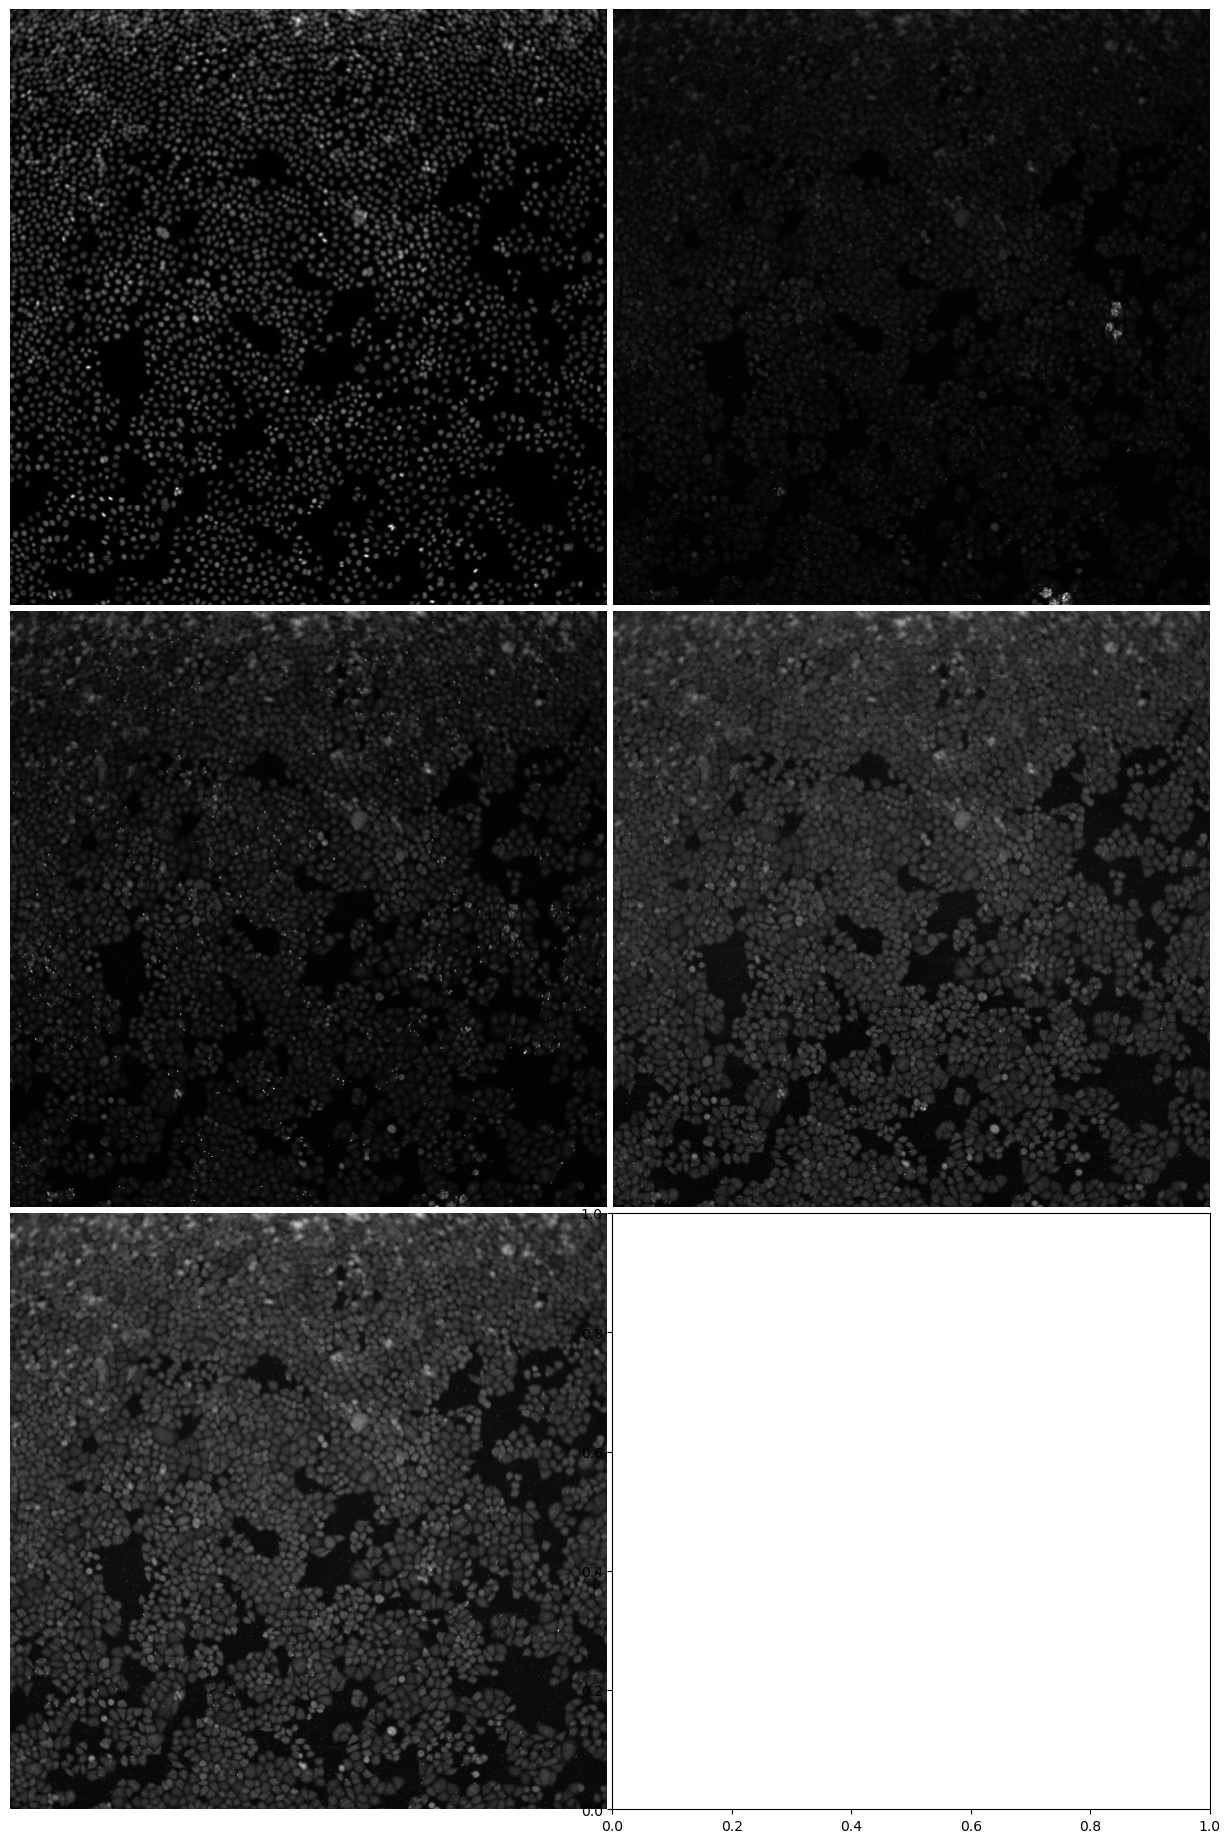

In [9]:
if SBS_IMAGES_DIR_FP is not None:
    # Get test sbs sample
    sbs_sample = get_sample_fps(
        sbs_samples,
        well=sbs_samples["well"][0],
        tile=sbs_samples["tile"][0],
        cycle=sbs_samples["cycle"][0],
        channel_order=SBS_CHANNEL_ORDER,
    )

    # Convert test sbs sample to tiff
    sbs_image = nd2_to_tiff(sbs_sample, SBS_CHANNEL_ORDER_FLIP, verbose=True)
    # Create micropanel to display converted samples
    print("Converted SBS test sample:")
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.show()

### Test phenotype conversion

Processing file 1/1: /lab/barcheese01/brieflow_screens/denali-data/input_ph/plate_1/20240121_140219_589/P001_Pheno_20x_Wells-A1_Points-001__Channel_AF750,Cy3,GFP,DAPI.nd2
Original dimensions for /lab/barcheese01/brieflow_screens/denali-data/input_ph/plate_1/20240121_140219_589/P001_Pheno_20x_Wells-A1_Points-001__Channel_AF750,Cy3,GFP,DAPI.nd2: ('Z', 'C', 'Y', 'X')
Array shape after processing: (4, 2400, 2400)
Final dimensions (CYX): (4, 2400, 2400)
Converted phenotype test sample:


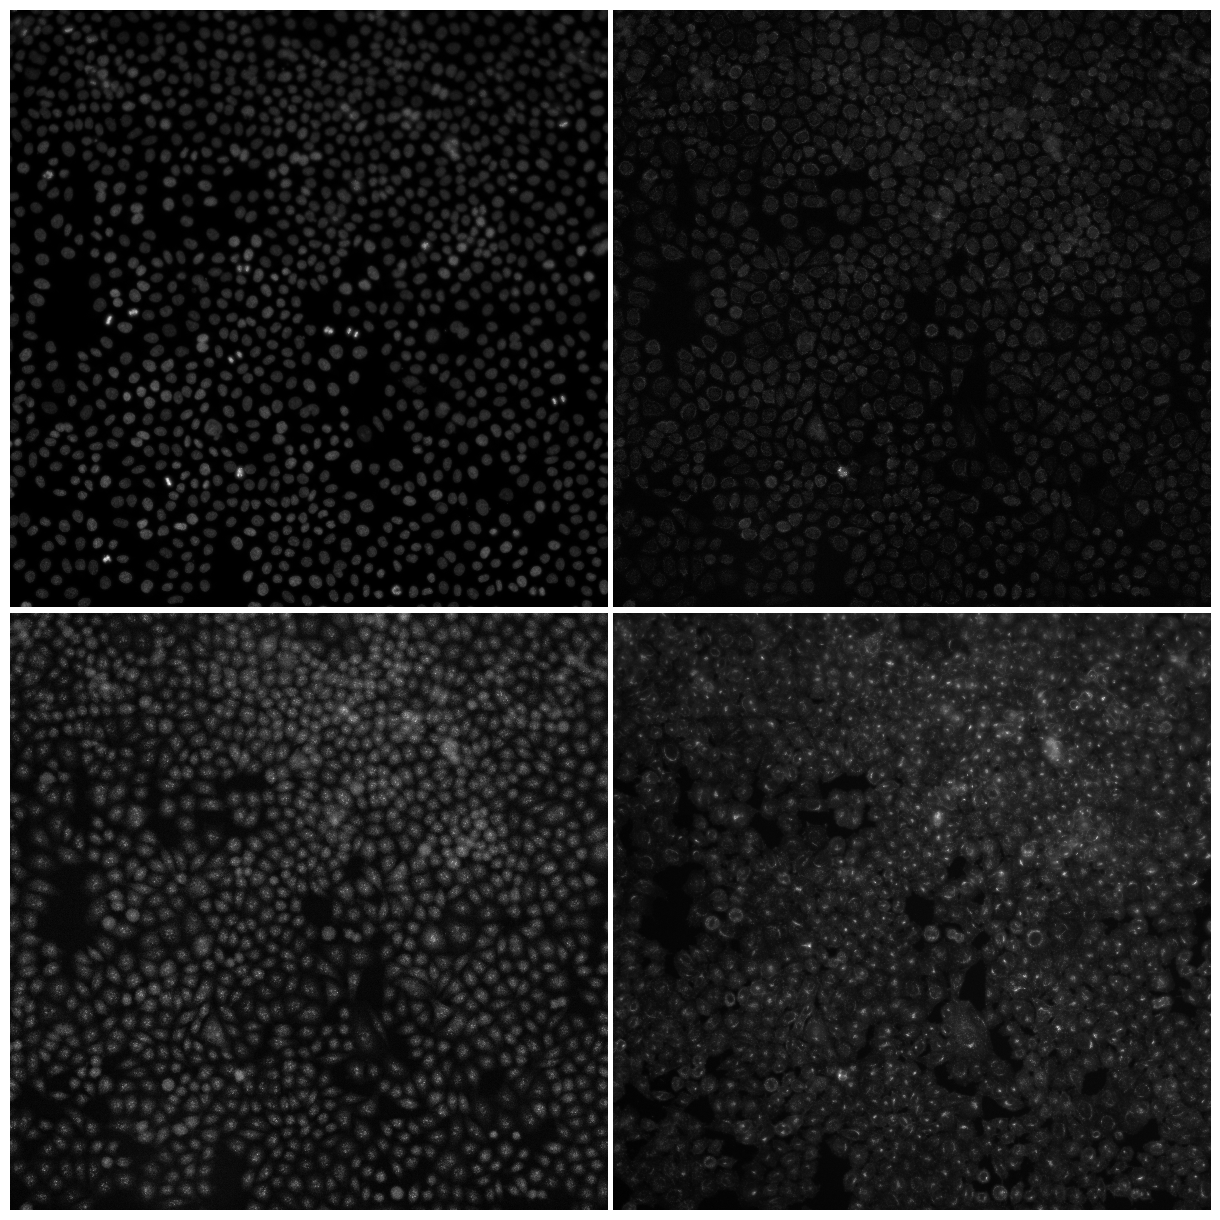

In [10]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        well=phenotype_samples["well"][0],
        tile=phenotype_samples["tile"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
    )
    # Convert test phenotype sample to tiff
    phenotype_image = nd2_to_tiff(
        phenotype_sample, PHENOTYPE_CHANNEL_ORDER_FLIP, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

## Create config file with params

In [11]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "phenotype_channel_order": PHENOTYPE_CHANNEL_ORDER,
    "phenotype_round_order": PHENOTYPE_ROUND_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)